## Investigating PFT Composition on Surface Files

## Setup

In [76]:
import os
import xarray as xr
import pandas as pd
import dask
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy
import functools
import glob
import scipy

import fates_calibration_library.utils as utils
import fates_calibration_library.surface_data_functions as surface
import fates_calibration_library.plotting_functions as plotting

## Functions

In [69]:
def get_dom_pft(dat, clm_pfts, clm_fates_ind, threshold):
    
    all_pfts = np.append(dat.PCT_NAT_PFT.values, dat.PCT_CFT.values)
    non_veg = all_pfts[0]
    veg = all_pfts[1:]
    
    if all_pfts.sum() >= threshold:
        if non_veg >= threshold:
            veg_group = 'not_vegetated'
        else:
            sum_veg = veg.sum()
            veg_prop = (veg/sum_veg)*100.0
            sorted_pfts = sorted(veg_prop, reverse=True)
            pft_sort = np.flip(np.argsort(veg_prop))
    
            if sorted_pfts[0] >= threshold:
                dom_pft_inds = [pft_sort[0].tolist()]
            else:
                cumul_prop = sorted_pfts[0]
                for i in range(1, len(sorted_pfts)):
                    cumul_prop = cumul_prop + sorted_pfts[i]
                    if cumul_prop >= threshold:
                        dom_pft_inds = pft_sort[:i+1].tolist()
                        break
            dom_pfts = [clm_fates_ind[i+1] for i in sorted(dom_pft_inds)]
            veg_group = '-'.join(dom_pfts)
    else:
        veg_group = '-'

    return veg_group

def get_pft_index(dat, veg_group_lut):
    pfts = dat.dominant_pft.values
    ind = np.where(veg_group_lut.dominant_pft == pfts)[0]
    if len(ind) > 0:
        out = ind[0]
    else:
        out = 999
    return out

def get_pft_grouping(dat, veg_group_lut):
    pfts = dat.dominant_pft.values
    ind = np.where(veg_group_lut.dominant_pft == pfts)[0]
    if len(ind) > 0:
        out = veg_group_lut.pft_group[ind[0]]
    else:
        out = "NA"
    return out

def make_dompft_grid(surdat, clm_pfts, clm_fates_ind, threshold):
    
    lat = surdat.lat.data
    lon = surdat.lon.data
    

    surdat['dominant_pft'] = xr.DataArray(
        data='-'*500,
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], lon),
            lat=(["lat"], lat),
        )
    )

    lat = np.unique(surdat.lat)
    lon = np.unique(surdat.lon)

    # first get lut
    for i in range(len(lon)):
        for j in range(len(lat)):
            surdat.dominant_pft.data[j, i] = get_dom_pft(surdat.isel(lat=j).isel(lon=i), clm_pfts, clm_fates_ind, threshold)

    lut = np.unique(surdat.dominant_pft)
    lut = pd.DataFrame({'dominant_pft': np.unique(surdat.dominant_pft)})
    lut['ind'] = lut.index

    # map to index
    for i in range(len(lon)):
        for j in range(len(lat)):
            surdat.dominant_pft_ind.data[j, i] = get_pft_index(surdat.isel(lat=j).isel(lon=i), lut)

    lut_inds = np.unique(lut.ind)
    num_gridcells = []
    for ind in lut_inds:
        sub = surdat.where(surdat.dominant_pft_ind == ind)
        cells = sub['dominant_pft_ind'].values
        num_gridcells.append(len(cells[~np.isnan(cells)]))

    lut['num_gridcells'] = num_gridcells
    lut['pft_count'] = lut['dominant_pft'].str.split('-').str.len()

    return surdat, lut

In [202]:
def get_dom_pfts(dat, threshold):
    all_pfts = np.append(dat.PCT_NAT_PFT.values, dat.PCT_CFT.values)
    non_veg = all_pfts[0]
    
    veg = all_pfts[1:]
    
    if (all_pfts.sum() >= threshold) & (non_veg <= 50):

            sum_veg = veg.sum()
            veg_prop = (veg/sum_veg)*100.0
            
            sorted_pfts = sorted(veg_prop, reverse=True)
            pft_sort = np.flip(np.argsort(veg_prop))
            
            if sorted_pfts[0] >= threshold:
                dom_pft_inds = [pft_sort[0].tolist()]
            else:
                cumul_prop = sorted_pfts[0]
                for i in range(1, len(sorted_pfts)):
                    cumul_prop = cumul_prop + sorted_pfts[i]
                    if cumul_prop >= threshold:
                        dom_pft_inds = pft_sort[:i+1].tolist()
                        break
            
            clm_pft_ind = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
            dom_pfts = [clm_pft_ind[i] for i in sorted(dom_pft_inds)]

    else:
        if non_veg >= threshold:
            dom_pfts = [0]
        else:
            dom_pfts = 0
        
    return dom_pfts

In [163]:
# surface file
surdat_dir = "/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/surfdata_esmf/ctsm5.3.0/"
surdat_2deg = os.path.join(surdat_dir, "surfdata_1.9x2.5_hist_2000_16pfts_c240908.nc")


# fates-clm index mapping
fates_clm_mapping_file = os.path.join("/glade/work/afoster/FATES_calibration/fates_calibration_library/configs",
                                      "fates_clm_index.yaml")
fates_clm_mapping = utils.get_config_file(fates_clm_mapping_file)

# pft names
param = xr.open_dataset(os.path.join('/glade/campaign/cesm/cesmdata/inputdata/lnd/clm2/paramdata/ctsm60_params_nfix.c241119.nc'))
pft_names = [str(f).replace("b'", "").strip().replace(" ", "").replace("'", "") for f in param.pftname.values]
clm_pfts = pft_names[0:17]

In [18]:
clm_fates_ind = {0: "not_vegetated",
                 1: "needleleaf_evergreen_extratrop_tree",
                 2: "needleleaf_evergreen_extratrop_tree",
                 3: "needleleaf_colddecid_extratrop_tree",
                 4: "broadleaf_evergreen_tropical_tree",
                 5: "broadleaf_evergreen_extratrop_tree",
                 6: "broadleaf_hydrodecid_tropical_tree",
                 7: "broadleaf_colddecid_extratrop_tree",
                 8: "broadleaf_colddecid_extratrop_tree",
                 9: "broadleaf_evergreen_extratrop_shrub",
                 10: "broadleaf_colddecid_extratrop_shrub",
                 11: "broadleaf_colddecid_arctic_shrub",
                 12: "arctic_c3_grass",
                 13: "cool_c3_grass",
                 14: "c4_grass",
                 15: "c3_crop",
                 16: "c3_irrigated"}

In [173]:
veg_combos = {
    "Boreal shrubland": {tuple([12])},
    "Tundra": {tuple([11]),tuple(sorted([11, 12]))},
    "Boreal forest": {tuple([2]),tuple(sorted([2,11, 12])),tuple(sorted([2, 12])),tuple(sorted([2, 11]))},
    "Siberian larch" : {tuple(sorted([3])),tuple(sorted([11,3])),tuple(sorted([12,3])),tuple(sorted([11,12,3]))},
    
    "Tropical rainforest" : {tuple(sorted([4]))},
    "Tropical savanna": {tuple(sorted([4,14])),tuple(sorted([14]))},
    "Subtropical savanna" : {tuple(sorted([6,14])),tuple(sorted([4,6])),tuple(sorted([4,6,14]))},

    "Grasslands" : {tuple(sorted([13])),tuple(sorted([13,15])),tuple(sorted([13,14])),tuple(sorted([13,14,15]))},
    "Shrubland" :  {tuple(sorted([10,13])),tuple(sorted([10,14])),tuple(sorted([10,13,14])),tuple(sorted([10,13,15])),tuple(sorted([10,14,15])),tuple(sorted([10,13,14,15]))},
    
    
    "Mixed deciduous temperate forest" :  {tuple(sorted([7])),
                                           tuple(sorted([1,7])),
                                           tuple(sorted([7,13])),
                                           tuple(sorted([7,14])),
                                           tuple(sorted([7,15])),
                                           tuple(sorted([1,7,13])),
                                           tuple(sorted([1,7,14])),
                                           tuple(sorted([1,7,15])),
                                           tuple(sorted([1,7,13,15])),
                                           tuple(sorted([1,7,14,15])),
                                           tuple(sorted([1,7,13,14])),
                                           tuple(sorted([7,13,14])),
                                           tuple(sorted([7,13,15])),
                                           tuple(sorted([7,14,15])),
                                           tuple(sorted([7,13,14,15])),
                                           tuple(sorted([1,7,13,14,15]))},

    "Conifer forest" : {tuple(sorted([1])),
                        tuple(sorted([1,2])),
                        tuple(sorted([1,13])),
                        tuple(sorted([1,14])),
                        tuple(sorted([1,15])),
                        tuple(sorted([1,2,13])),
                        tuple(sorted([1,2,14])),
                        tuple(sorted([1,2,15])),
                        tuple(sorted([1,13,14])),
                        tuple(sorted([1,13,15])),
                        tuple(sorted([1,14,15])),
                        tuple(sorted([1,2,13,14])),
                        tuple(sorted([1,2,13,15])),
                        tuple(sorted([1,2,14,15])),
                        tuple(sorted([1,13,14,15])),
                        tuple(sorted([1,2,13,14,15]))},
    "Broadleaf deciduous boreal trees" : { tuple(sorted([8])),
               tuple(sorted([2,8])),
               tuple(sorted([8,12])),
               tuple(sorted([8,13])),
               tuple(sorted([8,15])),
               tuple(sorted([2,8,12])),
               tuple(sorted([2,8,13])),
               tuple(sorted([2,8,15])),
               tuple(sorted([8,12,13])),
               tuple(sorted([8,12,15])),
               tuple(sorted([8,13,15])),
               tuple(sorted([2,8,13,15])),
               tuple(sorted([2,8,12,13])),
               tuple(sorted([2,8,12,15])),
               tuple(sorted([2,8,12,13,15])),
              },

    "Broadleaf evergreen temperate tree" : {tuple(sorted([5])),
                    tuple(sorted([5,13])),
                    tuple(sorted([5,14])),
                    tuple(sorted([5,15])),
                    tuple(sorted([5,13,14])),
                    tuple(sorted([5,13,15])),
                    tuple(sorted([5,14,15])),
                    tuple(sorted([5,13,14,15]))}

}

In [170]:
surdat = surface.get_surdat(surdat_2deg)
filename = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_SP_0/run/BNF_v2.n01_ctsm5.3.012_transient_SP_0.clm2.h1.2000-02-01-00000.nc'
ds_sp = xr.open_dataset(filename)
landfrac = ds_sp.landfrac

In [212]:
# Find PFTs that sum to > 75% of vegetated portion of gridcell
threshold=75

lats = surdat.lat.values
lons = surdat.lon.values

surdat['dominant_pft_ind'] = xr.DataArray(
    data=999,
    dims=["lat", "lon"],
    coords=dict(
        lon=(["lon"], surdat.lon.data),
        lat=(["lat"], surdat.lat.data),
    )
)

for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        if landfrac.sel(lat=lat, method='nearest').sel(lon=lon,method='nearest')>0.25:
            dat = surdat.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
            dd = get_dom_pfts(dat, threshold)
            surdat.dominant_pft_ind.data[i, j] = dd
            print(dd)
        else:
           dd = 0
            #surdat.dominant_pft_ind.data[i, j] = 0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


ValueError: setting an array element with a sequence.

In [206]:
ds_out.dom_pfts.plot()

TypeError: Plotting requires coordinates to be numeric, boolean, or dates of type numpy.datetime64, datetime.datetime, cftime.datetime or pandas.Interval. Received data of type object instead.

In [174]:
# create dataset of 2D biome masks
biome_masks = {}

lat_values = ds_out.lat.values
lon_values = ds_out.lon.values

for biome_name, pft_combos in veg_combos.items():
    # Create a binary mask for the biome
    biome_mask = np.zeros((len(lat_values), len(lon_values)), dtype=int)  

    for i, lat in enumerate(lat_values):
        for j, lon in enumerate(lon_values):
            dom_pfts = ds_out.dom_pfts.values[i, j] 
            
            if dom_pfts is not None:
                sorted_pfts = tuple(sorted(dom_pfts))
                if sorted_pfts in pft_combos:
                    biome_mask[i, j] = 1  # Mark as 1 (true)

    # Store the mask in the dictionary
    biome_masks[biome_name] = (["lat", "lon"], biome_mask)


biome_ds = xr.Dataset(biome_masks, coords={"lat": lat_values, "lon": lon_values})

In [175]:
# plot all masks 

# Define a colormap for the biomes
biome_names = ['Tropical rainforest','Tropical savanna','Subtropical savanna','Broadleaf evergreen temperate tree','Grasslands','Shrubland',
               'Mixed deciduous temperate forest','Conifer forest','Siberian larch','Boreal forest','Broadleaf deciduous boreal trees','Boreal shrubland','Tundra']

# Create an empty array for the final categorical map
lat_values = biome_ds.lat.values
lon_values = biome_ds.lon.values
biome_map = np.zeros((len(lat_values), len(lon_values)))  # Default to 0 (background)

# Assign unique values to each biome
for idx, biome in enumerate(biome_names, start=1):
    biome_mask = biome_ds[biome].values
    biome_map[biome_mask == 1] = idx  # Assign unique integer value

In [178]:
wfile='/glade/u/home/djk2120/ctsm6_ppe/biomes/whit/whitkey.nc'
whit=xr.open_dataset(wfile)
ds_biome_maps = whit.copy()
ds_biome_maps['sudoku_biomes'] = (('lat', 'lon'), biome_map)
ds_biome_maps = ds_biome_maps.assign_coords(biome_names=biome_names)
ds_biome_maps = ds_biome_maps.drop_vars('biome_fg')
ds_biome_maps = ds_biome_maps.drop_vars('biome_name')

In [179]:
from matplotlib.colors import ListedColormap
colors = [
    "grey",
    "#004D19","#5D9945","darkseagreen","#E9DFC1",   # (tropic, tropic, savanna, eucalyptus)
    "#DECAA7", "#D2B48C", # (grasslands, shrublands)
    "#97A669","lightblue","teal",# (mixed decid, conifer, larch)
    "cadetblue","thistle","lavenderblush","lavender" # (boreal forest, aspen, boreal shrub, tundra)
    
]

cmap = ListedColormap(colors, name="earth_biomes_19")

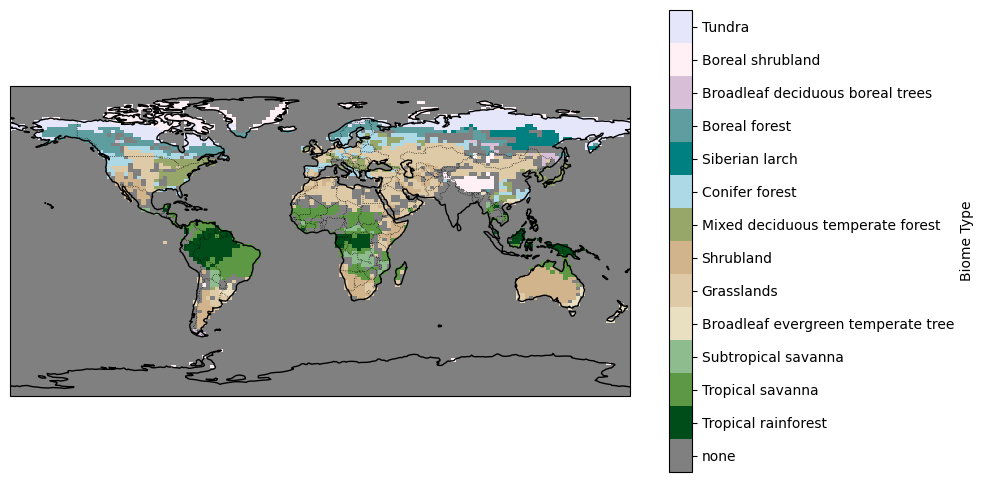

In [185]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
mesh = ax.pcolormesh(lon_values, lat_values, ds_biome_maps.sudoku_biomes, cmap=cmap, shading='auto', vmin=-0.5, vmax=13.5)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

cbar = plt.colorbar(mesh,ticks=np.arange(0, len(biome_names) + 1))
cbar.set_label("Biome Type")
cbar.set_ticks(np.arange(0, len(biome_names) + 1))
cbar.set_ticklabels(np.concatenate([np.array(['none']), np.array(biome_names)]))

#plt.savefig('sudoku_biome_map.png')
#plt.scatter(sg.grid1d_lon.values,sg.grid1d_lat.values,s=0.6,color='w')
#plt.savefig('sudoku_biome_map_wSG.png')